# Demo: Lineage-recorded data from Chan et al, (Nature 2019)

This demo uses data from: 

_Molecular recording of mammalian embryogenesis_

  - Chan et al (Nature 2019)
  - [https://doi.org/10.1038/s41586-019-1184-5](https://doi.org/10.1038/s41586-019-1184-5)


For this demo, you need the expression data (count matrix) for Embryo3 which can be found in the
NCBI GEO database under accession [GSM3302829](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3302829)

Specifically these three files:

- GSM3302829_embryo3_SeuratBarcodes.tsv.gz
- GSM3302829_embryo3_SeuratGenes.tsv.gz
- GSM3302829_embryo3_SeuratNorm.mtx.gz

The cell-type kernels (for interpreting lineage groups) are located at [GSE122187](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE122187)

- GSE122187_CellStateKernels.xls.gz	

Additionally, a reconstructed lineage tree is provided with this notebook (same directory) as made by [Cassiopeia](https://github.com/YosefLab/Cassiopeia)

- 0726_E2-2_tree_greedy_priors.processed.txt


## Covered Here

- Data preprocessing and filtering
- Computing Autocorrelation in Hotspot to identify lineage-related genes
- Computing local correlations between lineage genes to identify heritable modules
- Plotting modules, correlations, and module scores

In [1]:
import warnings; warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import hotspot
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

from scipy.io import mmread
from scipy.sparse import csr_matrix

In [2]:
counts_raw = mmread("GSM3302829_embryo3_SeuratNorm.mtx.gz")
counts_raw = csr_matrix(counts_raw)
barcodes = pd.read_table("GSM3302829_embryo3_SeuratBarcodes.tsv.gz", header=None)[0]
barcodes = [x+'-1' for x in barcodes] # to match the newick file
genes = pd.read_table("GSM3302829_embryo3_SeuratGenes.tsv.gz", header=None)[0]

In [3]:
# Load the tree and enumerate the leaves
from ete3 import Tree
tree = Tree("0726_E2-2_tree_greedy_priors.processed.txt", format=1)
leaves = set()
for tn in tree.traverse('postorder'):
    if tn.is_leaf():
        leaves.add(tn.name)
len(leaves)

1756

In [4]:
# Subset the count matrix to only the cells where the lineage was recoverable
is_valid = [x in leaves for x in barcodes]
is_valid_indices = np.nonzero(is_valid)[0]
valid_barcodes = [barcodes[i] for i in is_valid_indices]

counts = counts_raw[:, is_valid_indices].todense()
counts = pd.DataFrame(counts, index=genes, columns=valid_barcodes)

# Subset for only genes detected in at least 10 cells
counts = counts.loc[
    (counts > 0).sum(axis=1) >= 10
]

## Creating the Hotspot object

To start an analysis, first create the hotspot object
When creating the object, you need to specify:

- The gene counts matrix
- Which background model to use
- The latent space we are using to compute our cell metric
    - Here we use the inferred cell tree
- The per-cell scaling factor
    - Here we use the number of umi per barcode
    
In this case, only the *log-normalized counts* are made available.  In the Hotspot publication, we used the raw counts and the negative binomial ('danb') model.  However, to make this example easier to run, here we just supply the log-normalized counts and select the 'normal' model. 
    
Once the object is created, the neighborhood is then computed with `create_knn_graph`

The two options that are specificied are `n_neighbors` which determines the size of the neighborhood, and `weighted_graph`.

Here we set `weighted_graph=False` to just use binary, 0-1 weights (only binary weights are supported when using a lineage tree) and `n_neighbors=30` to create a local neighborhood size of the nearest 30 cells.  Larger neighborhood sizes can result in more robust detection of correlations and autocorrelations at a cost of missing more fine-grained, smaller-scale patterns.

In [5]:
# Create the Hotspot object and the neighborhood graph

hs = hotspot.Hotspot(counts, model='normal', tree=tree)

hs.create_knn_graph(
    weighted_graph=False, n_neighbors=30,
)

100%|██████████| 1756/1756 [00:16<00:00, 110.57it/s]


## Determining genes with heritable variation

Now we compute autocorrelations for each gene, using the lineage metric, to determine which genes have the most heritable variation.

In [6]:
hs_results = hs.compute_autocorrelations(jobs=1)

hs_results.head(15)

100%|██████████| 12440/12440 [00:04<00:00, 3046.79it/s]


,C,Z,Pval,FDR
Gene,,,,
Rhox5,0.202858,39.835987,0.000000e+00,0.000000e+00
Trap1a,0.182587,35.933251,4.622486e-283,2.204320e-279
Mt1,0.184857,35.929364,5.315884e-283,2.204320e-279
Mt2,0.179544,35.885161,2.602714e-282,8.094441e-279
Lgals2,0.179358,34.875108,8.864925e-267,2.205593e-263
Apom,0.175625,34.854555,1.816081e-266,3.765341e-263
Ttr,0.179074,34.795900,1.402761e-265,2.492907e-262
S100g,0.169737,33.828606,3.745067e-251,5.823579e-248
Apoa1,0.173526,33.700644,2.828200e-249,3.909201e-246


## Grouping genes into lineage-based modules

To get a better idea of what heritable expression patterns exist, it is helpful to group the genes into modules.

Hotspot does this using the concept of "local correlations" - that is, <br> 
correlations that are computed between genes between cells in the same neighborhood.

Here we avoid running the calculation for all Genes x Genes pairs and instead <br> only run this on genes that have significant lineage autocorrelation to begin with.

The method `compute_local_correlations` returns a Genes x Genes matrix of <br>
Z-scores for the significance of the correlation between genes.  This object <br>
is also retained in the `hs` object and is used in the subsequent steps.

In [7]:
# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.index[hs_results.FDR < 0.05]

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=2)


 27%|██▋       | 450/1685 [00:00<00:00, 4491.33it/s]

Computing pair-wise local correlation on 1685 features...


100%|██████████| 1418770/1418770 [01:17<00:00, 18344.96it/s]


Now that pair-wise local correlations are calculated, we can group genes into modules.

To do this, a convenience method is included `create_modules` which performs <br> 
agglomerative clustering with two caveats:

- If the FDR-adjusted p-value of the correlation between two branches exceeds `fdr_threshold`, <br>
then the branches are not merged.
- If two branches are two be merged and they are both have at least `min_gene_threshold` genes, <br>
then the branches are not merged.  Further genes that would join to the resulting merged module <br> (and are therefore ambiguous) either remain unassigned (if `core_only=True`) or are assigned to the module with the <br>
smaller average correlations between genes, i.e. the least-dense module (if `core_only=False`)

The output is a Series that maps gene to module number.  Unassigned genes are indicated with a module number of `-1`

This method was used to preserved substructure (nested modules) while still giving the analyst <br>
some control. However, since there are a lot of ways to do hierarchical clustering, you can also <br>
manually cluster using the gene-distances in `hs.local_correlation_z`



In [8]:
modules = hs.create_modules(
    min_gene_threshold=50, core_only=True, fdr_threshold=0.05
)

modules.value_counts()

 1    682
 2    566
-1    223
 3     84
 5     65
 4     65
Name: Module, dtype: int64

## Plotting module correlations

A convenience method is supplied to plot the results of `hs.create_modules`

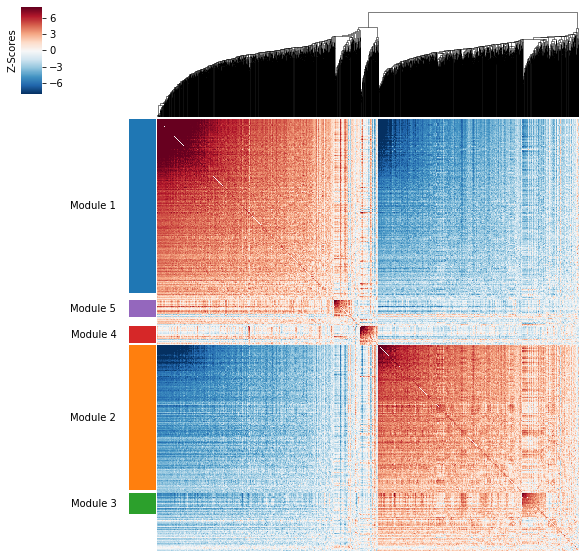

In [9]:
hs.plot_local_correlations()

To explore individual genes, we can look at the genes with the top *autocorrelation* <br>
in a given module as these are likely the most informative.

In [10]:
# Show the top genes for a module

module = 3

results = hs.results.join(hs.modules)
results = results.loc[results.Module == module]
results.sort_values('Z', ascending=False).head(10)

,C,Z,Pval,FDR,Module
Gene,,,,,
Klf1,0.083767,15.732653,4.517215e-56,5.251790e-54,3.0
Hba-x,0.067472,12.765132,1.283581e-37,1.078902e-35,3.0
Hbb-bh1,0.061915,12.301353,4.453501e-35,3.551381e-33,3.0
Hba-a1,0.058662,10.890564,6.392324e-28,4.036574e-26,3.0
Hbb-y,0.058233,10.754297,2.828191e-27,1.733137e-25,3.0
Gypa,0.053739,10.322431,2.789620e-25,1.644686e-23,3.0
Blvrb,0.049597,9.756170,8.679374e-23,4.633966e-21,3.0
Anp32b,0.047844,9.041718,7.711397e-20,3.647520e-18,3.0
Alad,0.042718,8.496494,9.770124e-18,4.191046e-16,3.0


To get an idea of what lineage patterns the module is referencing, we can plot the <br>
kernel values

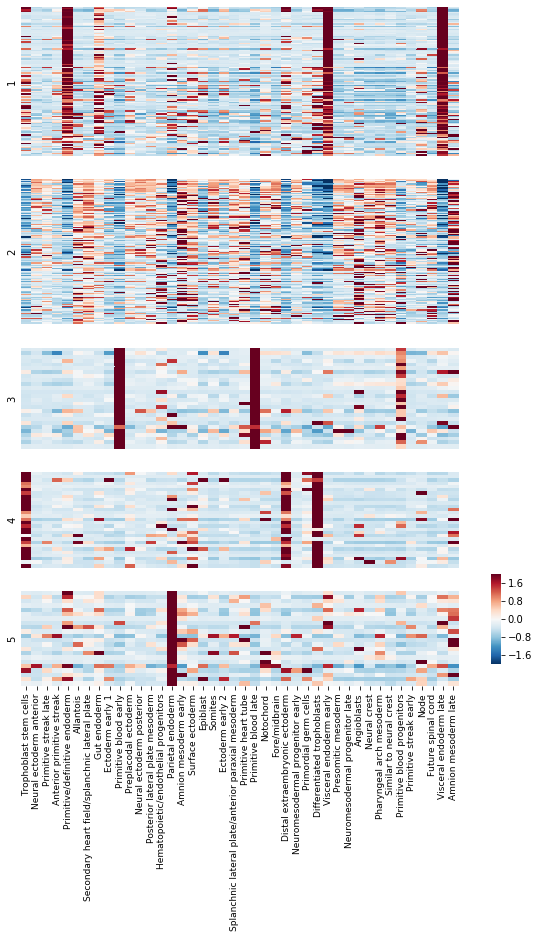

In [11]:
# Load Kernel values
import gzip
with gzip.open("GSE122187_CellStateKernels.xls.gz") as fin:
    kernels = pd.read_excel(fin, skiprows=1).set_index('Gene')
    
kernels = kernels.loc[
    :, kernels.columns.sort_values()
]

kernel_name_map = {
    0: "trophoblast stem cells",
    1: "neural ectoderm anterior",
    2: "primitive streak late",
    3: "anterior primitive streak",
    4: "primitive/definitive endoderm",
    5: "allantois",
    6: "secondary heart field/splanchnic lateral plate",
    7: "gut endoderm",
    8: "ectoderm early 1",
    9: "primitive blood early",
    10: "preplacodal ectoderm",
    11: "neural ectoderm posterior",
    12: "posterior lateral plate mesoderm",
    13: "hematopoietic/endothelial progenitors",
    14: "parietal endoderm",
    15: "amnion mesoderm early",
    16: "surface ectoderm",
    17: "epiblast",
    18: "somites",
    19: "ectoderm early 2",
    20: "splanchnic lateral plate/anterior paraxial mesoderm",
    21: "primitive heart tube",
    22: "primitive blood late",
    23: "notochord",
    24: "fore/midbrain",
    25: "distal extraembryonic ectoderm",
    26: "neuromesodermal progenitor early",
    27: "primordial germ cells",
    28: "differentiated trophoblasts",
    29: "visceral endoderm early",
    30: "presomitic mesoderm",
    31: "neuromesodermal progenitor late",
    32: "angioblasts",
    33: "neural crest",
    34: "pharyngeal arch mesoderm",
    35: "similar to neural crest",
    36: "primitive blood progenitors",
    37: "primitive streak early",
    38: "node",
    39: "future spinal cord",
    40: "visceral endoderm late",
    41: "amnion mesoderm late",
}

kernel_name_map = {k: v.capitalize() for k, v in kernel_name_map.items()}

kernels.columns = [kernel_name_map[x] for x in kernels.columns]

# Standardize each gene
kernels_z = kernels \
    .subtract(kernels.mean(axis=1), axis=0) \
    .divide(kernels.std(axis=1), axis=0)


# Plot the kernel values for the genes in each module
mods = hs.modules.unique()
mods = [x for x in mods if x != -1 and not np.isnan(x)]
mods = sorted(mods)

sizes = [(hs.modules == x).sum() for x in mods]
sizes = [np.log10(x) for x in sizes]

fig, axs = plt.subplots(
    len(mods), 1, gridspec_kw=dict(height_ratios=sizes, right=.8), 
    figsize=(9, 12.5)
)

cbax = fig.add_axes([.85, .15, .015, .1])

for ax, mod in zip(axs.ravel(), mods):

    plt.sca(ax)
    mod_genes = hs.modules.index[hs.modules == mod]
    mod_genes = pd.Index(mod_genes) & kernels.index
    
    last_plot = mod == max(mods)
    
    if last_plot:
        cbar=True
        cbar_ax=cbax
    else:
        cbar=False
        cbar_ax=None

    sns.heatmap(kernels_z.loc[mod_genes], vmin=-2, vmax=2,
                cmap="RdBu_r", ax=ax, xticklabels=True, rasterized=True,
                cbar=cbar, cbar_ax=cbar_ax)
    plt.ylabel(int(mod))

    plt.yticks([])

    if last_plot:
        ax.tick_params(labelsize=9)
    else:
        plt.xticks([])

plt.tight_layout()


## Summary Module Scores

To aid in the recognition of the general behavior of a module, Hotspot can compute <br>
aggregate module scores.

In [12]:
module_scores = hs.calculate_module_scores()

module_scores.head()

  0%|          | 0/5 [00:00<?, ?it/s]

Computing scores for 5 modules...


100%|██████████| 5/5 [00:00<00:00,  3.03it/s]


,1,2,3,4,5
AAACCTGAGAATAGGG-1,-6.993694,5.658538,1.238681,-0.743027,-0.372733
AAACCTGAGACCCACC-1,-2.767821,2.735488,-1.299466,0.587611,0.333043
AAACCTGAGCAGCGTA-1,1.070490,-0.881125,-0.715067,0.503891,0.083320
AAACCTGAGCCCAATT-1,2.906480,-1.453035,-1.730925,-0.576987,-0.339215
AAACCTGAGTACGACG-1,-0.778300,0.360248,0.019698,-0.247749,0.733445


Here we can visualize these module scores by plotting them over a UMAP of the cells

First we'll compute the UMAP

In [13]:
from sklearn.decomposition import PCA
from umap import UMAP

counts_z = counts \
    .subtract(counts.mean(axis=1), axis=0) \
    .divide(counts.std(axis=1), axis=0)

pca_data = PCA(n_components=20).fit_transform(counts_z.values.T)
umap_data = UMAP(n_neighbors=30, min_dist=.5).fit_transform(pca_data)
umap_data = pd.DataFrame(umap_data, index=counts.columns, columns=['UMAP1', 'UMAP2'])

/data/yosef2/users/david.detomaso/programs/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Next, let's use the Kernels to assign every cell to its closest profile

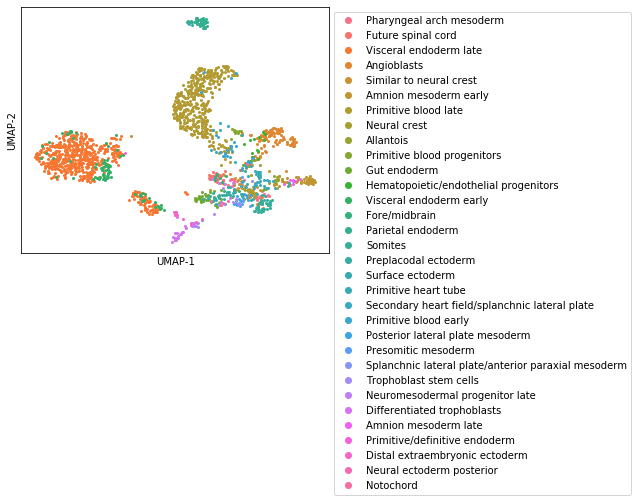

In [14]:
from scipy.spatial.distance import cdist

common = counts.index & kernels.index
dd = cdist(counts.loc[common].T, kernels.loc[common].T, metric='cosine')
dd = pd.DataFrame(dd, index=counts.columns, columns=kernels.columns)
assignment = dd.idxmin(axis=1).loc[counts.columns]

colors = sns.color_palette("husl", assignment.unique().size)
plt.figure(figsize=(9, 9))
for i, ct in enumerate(assignment.unique()):
    ii = assignment.index[assignment == ct]
    plt.plot(umap_data.loc[ii].UMAP1, umap_data.loc[ii].UMAP2,
            'o', ms=2, label=ct, color=colors[i])
    
plt.xticks([])
plt.yticks([])
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.subplots_adjust(right=.6, bottom=.5)
plt.legend(bbox_to_anchor=[1, 1], loc='upper left', markerscale=3);

Finally, we plot the module scores on top of the UMAP for comparison

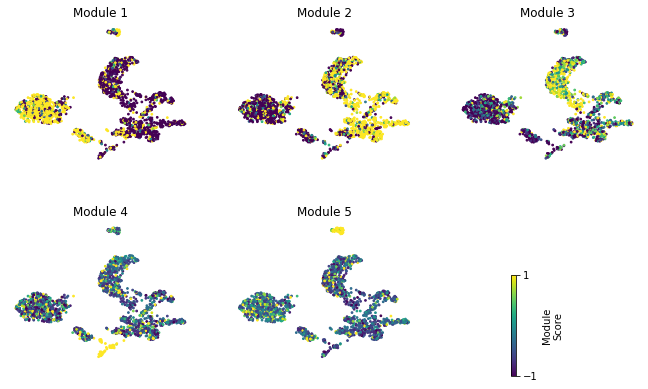

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(10, 7))
cax = fig.add_axes(
    [.72, .1, .007, .2]
)

for ax, mod in zip(axs.ravel(), hs.module_scores.columns):
    sc = hs.module_scores[mod]
    # vmin = np.percentile(sc, 5)
    # vmax = np.percentile(sc, 95)
    vmin = -1
    vmax = 1
    plt.sca(ax)
    sc = plt.scatter(
        umap_data.UMAP1, umap_data.UMAP2,
        s=3, c=sc, vmin=vmin, vmax=vmax,
        rasterized=True)
    plt.xticks([])
    plt.yticks([])
    plt.title("Module {}".format(mod))
    for sp in ax.spines.values():
        sp.set_visible(False)

axs[1, 2].remove()
plt.subplots_adjust(hspace=0.4)
plt.colorbar(sc, cax=cax, ticks=[vmin, vmax], label='Module\nScore')
plt.subplots_adjust(left=0.02, right=0.9, top=0.8)